# POS-tagging using LSTM (Long short-term memory)

This is LTSM part-of-speech tagger for Universal Dependencies data

**Author**: Ruslan Sabirov

**Collab link**: [link](https://drive.google.com/file/d/16AiR9PeczAvYw6v-MOIxaB3KlWZF7SKL/view?usp=sharing)

**Assignment description**: [link](https://leondz.github.io/iu-nlpml/assignment%20seq2seq.pdf)

## Preparations

### Installing and importing packages

*   Torch --- for building model

*   Torchnlp --- for downloading a dataset

*   Seaborn, pandas, sklearn --- for building and plotting confusion matrix


### Configuring reproducibility
Source: [link](https://pytorch.org/docs/stable/notes/randomness.html)

In [1]:
# Installing all necessary libraries
!pip install torch
!pip install torchnlp
!pip install pytorch-nlp

!pip install seaborn
!pip install sklearn
!pip install pandas
!pip install numpy

In [0]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from tqdm import tqdm

In [0]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Dataset

### Loading 

I am using [UD POS-tags](https://pytorchnlp.readthedocs.io/en/latest/_modules/torchnlp/datasets/ud_pos.html) dataset. Corpus of sentences annotated using Universal Dependencies annotation. The corpus comprises 254,830 words and 16,622 sentences, taken from various web media including weblogs, newsgroups, emails, reviews, and Yahoo! answers.

Data is already split into training and testing parts in proportion: 75% for the training set and 25% for the testing set.

Data is loaded by `torchnlp.dataset` module.

### Preprocessing

Each word, sentence, and tag are assigned with unique ids, so that it is easier to process by Pytorch model.


In [0]:
from torchnlp.datasets import ud_pos_dataset
from torch.utils import data


class Dataset(data.Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        X = [x.lower() for x in self.data[index]['tokens']]
        y = self.data[index]['ud_tags']
        return X, y
    

train_dataset = ud_pos_dataset(directory='data/UD_English-EWT', train=True)
test_dataset = ud_pos_dataset(directory='data/UD_English-EWT', test=True)

In [0]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype=torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype=torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype=torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)

word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in train_dataset + test_dataset:
    for word, pos_tag in zip(sentence['tokens'], sentence['ud_tags']):
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

idx_to_word = {idx: word for word, idx in word_to_idx.items()}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
TAGS = list(tag_to_idx.keys())

word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

Most popular words: [('.', 9759), ('the', 9014), (',', 7851), ('to', 5667), ('and', 5386), ('a', 4089), ('of', 3951), ('I', 3516), ('in', 3250), ('is', 2419), ('you', 2188), ('that', 2144), ('for', 1991), ('it', 1642), ('-', 1609)] 

Most popular tags: [('NOUN', 38913), ('PUNCT', 26785), ('VERB', 25736), ('PRON', 20735), ('ADP', 19656), ('DET', 18181), ('PROPN', 15022), ('ADJ', 14170), ('AUX', 13838), ('ADV', 11773), ('CCONJ', 7446), ('PART', 6197), ('NUM', 4535), ('SCONJ', 4230), ('X', 986)] 



<BarContainer object of 17 artists>

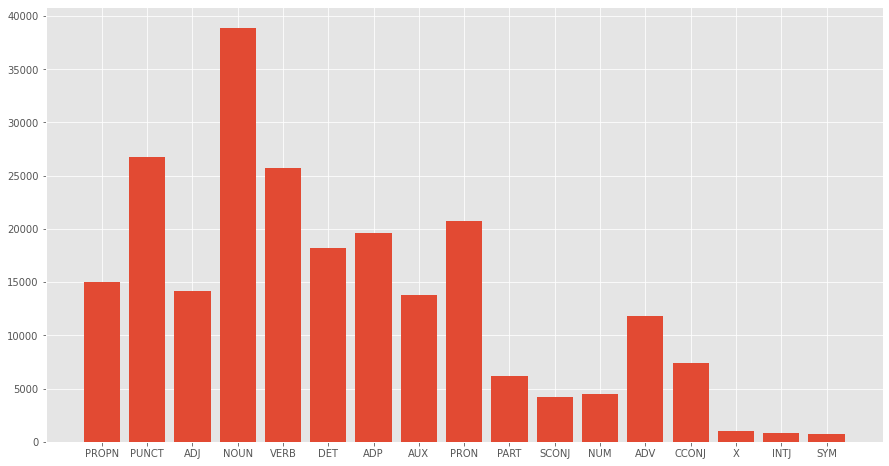

In [81]:
from itertools import chain
from collections import Counter

all_words = list(chain(*[s['tokens'] for s in train_dataset + test_dataset]))
words_counter = Counter(all_words)
print('Most popular words:', words_counter.most_common(15), '\n')

all_tags = list(chain(*[s['ud_tags'] for s in train_dataset + test_dataset]))
tags_counter = Counter(all_tags)
print('Most popular tags:', tags_counter.most_common(15), '\n')

plt.figure(figsize=(15, 8))
plt.bar(x=tags_counter.keys(), height=tags_counter.values())

## Model

These two models are using **stochastic gradient descent**. Both of them were inherited from `nn.Module` so that all functionality of PyTorch model is available to them. 

I have also tried to apply mini-batch gradient descent with padding, but have faced a large number of problems and could not fix them. 


### Simple LSTM tagger
It takes a sentence as an input and returns a list of tags probabilities for each token. For each word, it uses the current word and long-term memory consisting of previous words.

1. Take a sequence of words as an input.
2. Embed the sequence into an embedding space (dimension of the space is a hyperparameter).
3. Run the standard LSTM model.


### DualLSTMTagger
In addition to sentence representation, it also gets words representation so that it can also consider character-level features of words. There is an intuition behind this approach: word ending sometimes is very useful in POS-tags prediction (e.g., `-ies` suffix most probably defines plural noun).

1. Word level LSTM will take in a sequence of words and convert them into the word embedding space. 
2. Take the words sequentially and run the character level LSTM model, and take its hidden state and feed it back to the word LSTM model.
3. For every word and word embedding, the word level model then runs LSTM on the sequence of words and outputs the predictions for every tag. 


In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


class DualLSTMTagger(nn.Module):
    def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
        super(DualLSTMTagger, self).__init__()
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
        self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
        
        self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
        self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
        
    def forward(self, sentence, words):
        embeds = self.word_embedding(sentence)
        char_hidden_final = []
        for word in words:
            char_embeds = self.char_embedding(word)
            _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
            word_char_hidden_state = char_hidden.view(-1)
            char_hidden_final.append(word_char_hidden_state)
        char_hidden_final = torch.stack(tuple(char_hidden_final))
        
        combined = torch.cat((embeds, char_hidden_final), 1)

        lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## Train / Text

I am counting both sentence accuracy and token accuracy. Sentence accuracy is the proportion of sentences that were classified correctly. Tokens accuracy is the proportion of tokens that were classified correctly (no matter of sentence). Here is a table of accuracies depending on the used model:


```
ALGORITHM NAME  | SAMPLE (train) | SAMPLE (test) | TOKEN (train) | TOKEN (test)
Simple LSTM  ⠀ ⠀| 12%  ⠀⠀⠀⠀⠀⠀ ⠀| 07% ⠀⠀⠀⠀⠀⠀ ⠀ | 68% ⠀⠀⠀⠀⠀⠀ ⠀| 64%
Dual LSTM     ⠀⠀| 27% ⠀⠀⠀⠀⠀⠀ ⠀ | 24% ⠀⠀⠀⠀⠀⠀ ⠀ | 87% ⠀⠀⠀⠀⠀⠀  | 82%
```

It is much better than random prediction or always-most-popular-tag prediction.


In [7]:
from tqdm import tqdm, trange
from termcolor import colored

WORD_EMBEDDING_DIM = 1024
CHAR_EMBEDDING_DIM = 128
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 1024
EPOCHS = 5

model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)
#model = LSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, word_vocab_size, tag_vocab_size)
model_name = model.__class__.__name__

use_cuda = torch.cuda.is_available()
if use_cuda:
    print(colored('Cuda', 'red'), use_cuda)
else:
    print('Cuda', use_cuda)
device = torch.device('cuda:0' if use_cuda else 'cpu')
if use_cuda:
    model.cuda()

loss_function = nn.NLLLoss() #  Negative Log Likelihood loss (NLLLoss)
optimizer = optim.Adam(model.parameters(), lr=0.01)


print('TRAIN')
model.train()
loss_list = []
sent_acc_list = []
word_acc_list = []
for epoch in range(EPOCHS):
    loss = 0 
    word_acc = sent_acc = 0
    words_num = 0
    for i in trange(len(train_dataset)):
        sentence_tag = train_dataset[i]

        words = [sequence_to_idx(s, char_to_idx).to(device)
                  for s in sentence_tag['tokens']]
        sentence = sentence_tag['tokens']
        sentence = (sequence_to_idx(sentence, word_to_idx)).to(device)
        targets = sentence_tag['ud_tags']
        targets = (sequence_to_idx(targets, tag_to_idx)).to(device)

        model.zero_grad()
        
        if isinstance(model, LSTMTagger):
            tag_scores = model(sentence)
        else:
            tag_scores = model(sentence, words)

        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)

        words_num += len(sentence)
        sent_acc += int(all(targets == indices))
        word_acc += torch.sum(torch.tensor(targets == indices, dtype=torch.float))


    loss = loss / len(train_dataset)
    word_acc = word_acc / words_num
    sent_acc = sent_acc / len(train_dataset)

    loss_list.append(loss)
    sent_acc_list.append(sent_acc)
    word_acc_list.append(word_acc)
    print(f'Epoch {epoch},\tLoss {loss:.2f}\tSentence accuracy: {sent_acc:.2f}\tWord accuracy: {word_acc:.2f}')


train_sent_acc, train_word_acc, train_loss = sent_acc_list, word_acc_list, loss_list


Cuda True


  0%|          | 3/12543 [00:00<07:19, 28.52it/s]

TRAIN


  0%|          | 3/12543 [00:00<07:04, 29.51it/s]

Epoch 0,	Loss 0.00	Sentence accuracy: 0.17	Word accuracy: 0.79


  0%|          | 3/12543 [00:00<06:58, 29.95it/s]

Epoch 1,	Loss 0.00	Sentence accuracy: 0.21	Word accuracy: 0.84


  0%|          | 4/12543 [00:00<06:44, 31.03it/s]

Epoch 2,	Loss 0.00	Sentence accuracy: 0.23	Word accuracy: 0.85


  0%|          | 3/12543 [00:00<06:58, 29.94it/s]

Epoch 3,	Loss 0.00	Sentence accuracy: 0.25	Word accuracy: 0.86


100%|██████████| 12543/12543 [05:49<00:00, 27.47it/s]

Epoch 4,	Loss 0.00	Sentence accuracy: 0.27	Word accuracy: 0.87


In [17]:
def test(dataset):
    print('TESTING')
    model.eval()
    with torch.no_grad():
        word_acc = sent_acc = 0
        words_num = 0
        loss = 0
        samples_tagged = []

        for i in trange(len(dataset)):
            sentence_tag = dataset[i]
            sentence, targets = sentence_tag['tokens'], sentence_tag['ud_tags']
            if len(sentence) != len(targets): # some sample are incorrect
                continue # skip them
            
            words = [sequence_to_idx(s, char_to_idx).to(device)
                  for s in sentence_tag['tokens']]
            sentence = (sequence_to_idx(sentence, word_to_idx)).to(device)
            targets = (sequence_to_idx(targets, tag_to_idx)).to(device)

            assert len(sentence) == len(targets)

            model.zero_grad()
            if isinstance(model, LSTMTagger):
                tag_scores = model(sentence)
            else:
                tag_scores = model(sentence, words)
            
            
            _, indices = torch.max(tag_scores, 1)
            words_num += len(sentence)

            loss_f = loss_function(tag_scores, targets)
            loss += loss_f.item()

            sent_acc += int(all(targets == indices))
            word_acc += torch.sum(torch.tensor(targets == indices, dtype=torch.float))

            sentence = [idx_to_word[idx] for idx in sentence.tolist()]
            targets = [idx_to_tag[idx] for idx in targets.tolist()]
            indices = [idx_to_tag[idx] for idx in indices.tolist()]
            samples_tagged.append([sentence, targets, indices])

        word_acc = word_acc / words_num
        sent_acc = sent_acc / len(dataset)

        print(f'\nTEST,\tSentence accuracy: {sent_acc:.2f}\tWord accuracy: {word_acc:.2f}')

    return sent_acc, word_acc, loss, samples_tagged

test_sent_acc, test_word_acc, test_loss, samples_tagged = test(test_dataset)


  1%|          | 16/2077 [00:00<00:13, 153.78it/s]

TESTING


100%|██████████| 2077/2077 [00:11<00:00, 176.36it/s]


TEST,	Sentence accuracy: 0.24	Word accuracy: 0.82


ERROR! Session/line number was not unique in database. History logging moved to new session 63


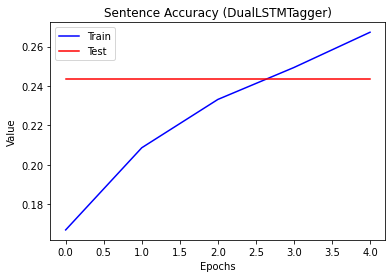

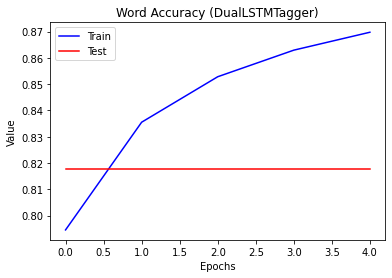

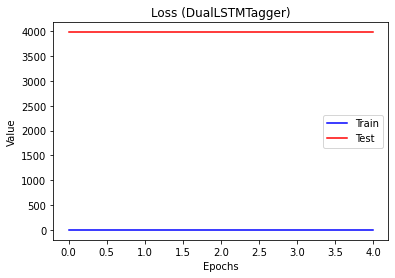

In [22]:
model_name = model.__class__.__name__

plt.plot(train_sent_acc, c='blue', label='Train')
plt.plot([test_sent_acc] * EPOCHS, c='red', label='Test')
plt.title(f'Sentence Accuracy ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.plot(train_word_acc, c='blue', label='Train')
plt.plot([test_word_acc] * EPOCHS, c='red', label='Test')
plt.title(f'Word Accuracy ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.plot(train_loss, c='blue', label='Train')
plt.plot([test_loss] * EPOCHS, c='red', label='Test')
plt.title(f'Loss ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

## Examples of classified sentences

Correctly classified sentences are represented with green, incorrect ones with red.

In [24]:
def print_tagged_sentence(sentence, tags, color):
    for i in range(len(sentence)):
        print(sentence[i], end='\\')
        print(colored(tags[i], color), end='   ')
    print()

samples_tagged.sort(key=lambda x: x[1] == x[2])
print('MODEL', model_name, '\n')
for example in samples_tagged[:5] + samples_tagged[-5:]:
    sent, true, pred = example
    if true == pred:
        print('Correctly')
        print_tagged_sentence(sent, true, 'blue')
        print_tagged_sentence(sent, pred, 'green')
    else:
        print('Incorrectly')
        print_tagged_sentence(sent, true, 'blue')
        print_tagged_sentence(sent, pred, 'red')
    print()
    print()

MODEL DualLSTMTagger 

Incorrectly
What\PRON   if\SCONJ   Google\PROPN   Morphed\VERB   Into\ADP   GoogleOS\PROPN   ?\PUNCT   
What\PRON   if\SCONJ   Google\ADV   Morphed\VERB   Into\ADV   GoogleOS\NOUN   ?\PUNCT   


Incorrectly
What\PRON   if\SCONJ   Google\PROPN   expanded\VERB   on\ADP   its\PRON   search\NOUN   -\PUNCT   engine\NOUN   (\PUNCT   and\CCONJ   now\ADV   e-mail\NOUN   )\PUNCT   wares\NOUN   into\ADP   a\DET   full\ADV   -\PUNCT   fledged\ADJ   operating\NOUN   system\NOUN   ?\PUNCT   
What\PRON   if\SCONJ   Google\ADV   expanded\VERB   on\ADP   its\PRON   search\VERB   -\PUNCT   engine\NOUN   (\PUNCT   and\CCONJ   now\ADV   e-mail\NOUN   )\PUNCT   wares\VERB   into\ADP   a\DET   full\ADJ   -\PUNCT   fledged\VERB   operating\VERB   system\NOUN   ?\PUNCT   


Incorrectly
[\PUNCT   via\ADP   Microsoft\PROPN   Watch\PROPN   from\ADP   Mary\PROPN   Jo\PROPN   Foley\PROPN   ]\PUNCT   
[\PUNCT   via\ADP   Microsoft\PROPN   Watch\NOUN   from\ADP   Mary\PROPN   Jo\NOUN   Foley\

## Confusion matrix

Here is a **confusion matrix**, each row and column is labeled as one of the tags. 
`confusion_matrix[row][column]` represents _propotion_ of tokens that actually have `row` tag but were classified as `column` tag.

Here are **some observations**
* Most of the correctly classified tokens belong to tags `NOUN` `PUNCT`.

* Most of the wrongly classified tokens belong to tags `X` `INTJ`, `SYM`.

* Most of the wrong predictions were made where actual `PROPN` tag was classified as `NOUN`. That is understandable because `PROPN` is very similar to `NOUN` in terms of syntax and semantics.

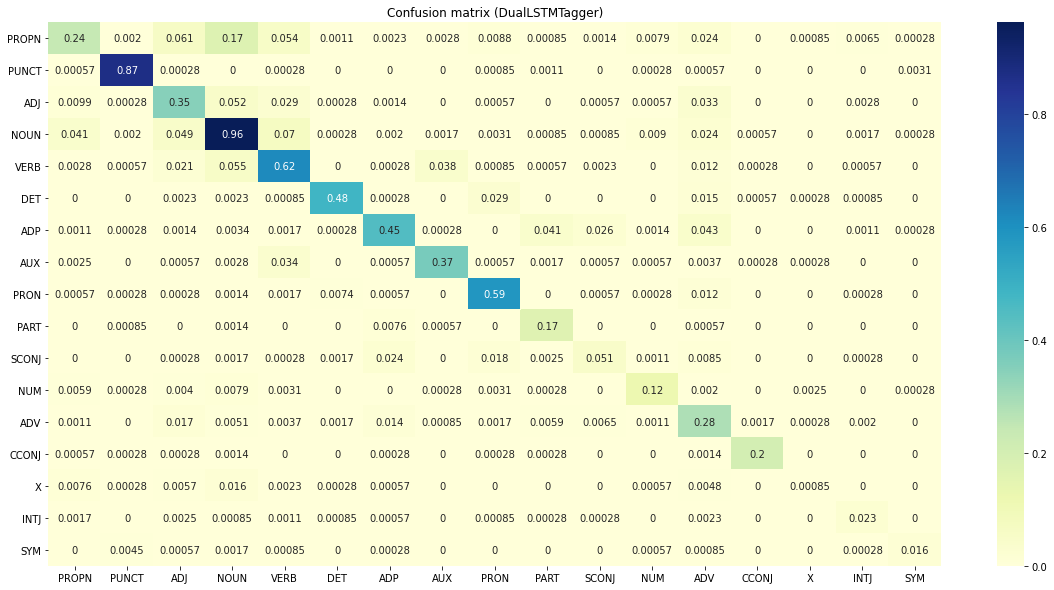

In [46]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.metrics import confusion_matrix

y_true = list(chain(*[s[1] for s in samples_tagged]))
y_pred = list(chain(*[s[2] for s in samples_tagged]))
cm = confusion_matrix(y_true, y_pred, labels=TAGS)
cm = cm / np.linalg.norm(cm, ord=2)

df_cm = pd.DataFrame(cm, index=TAGS, columns=TAGS)
plt.figure(figsize=(20, 10))
plt.title(f'Confusion matrix ({model_name})')
sn.heatmap(df_cm, annot=True, cmap='YlGnBu')